In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import minimize_scalar, minimize
from time import time
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('paper')
import sys
sys.path.append('..')

In [2]:
from osd import Problem
from osd.components import GaussNoise, SmoothSecondDifference, SparseFirstDiffConvex, SparseSecondDiffConvex
from osd.utilities import progress
import cvxpy as cvx
# SOLVER = 'MOSEK'
SOLVER = 'SCS'

# Convex example, $K=3$

In [13]:
np.random.seed(142)
t = np.linspace(0, 250, 1000)
c0 = 0.1 * np.random.randn(len(t))
c2 = 2 * np.abs(signal.sawtooth(2 * np.pi / 50 * t))
# c3 = 0.5 * (np.sin(2 * np.pi * t * 5 / (500.)) + np.cos(2 * np.pi * t * 7 / (550.)))
c3 = 0.25 * (np.sin(2 * np.pi * t * 5 / (500.)) + np.cos(2 * np.pi * t * 2.5 / (500.) - 50))
y = np.sum([c0, c2, c3], axis=0)
signal1 = c2
signal2 = c3
components = [c0, c2, c3]

In [9]:
# np.random.seed(42)
# t = np.linspace(0, 1000, 3000)
# signal1 = np.sin(2 * np.pi * t * 1 / (500.))
# signal2 = signal.square(2 * np.pi * t * 1 / (450.))
# y = signal1 + signal2 + 0.25 * np.random.randn(len(signal1))

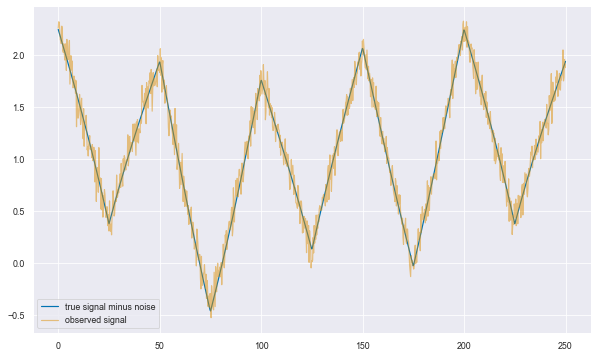

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(t, signal1 + signal2, label='true signal minus noise')
plt.plot(t, y, alpha=0.5, label='observed signal')
plt.legend()
plt.show()

# Solve problem all at once with CVXPY

In [22]:
problem = Problem(data=y, components=[GaussNoise, SparseSecondDiffConvex(vmax=2, vmin=0),
                                      SmoothSecondDifference])
problem.weights.value = [1, 2e0, 1e4]
problem.decompose(solver='MOSEK')
problem.problem.value

10.568513534098205

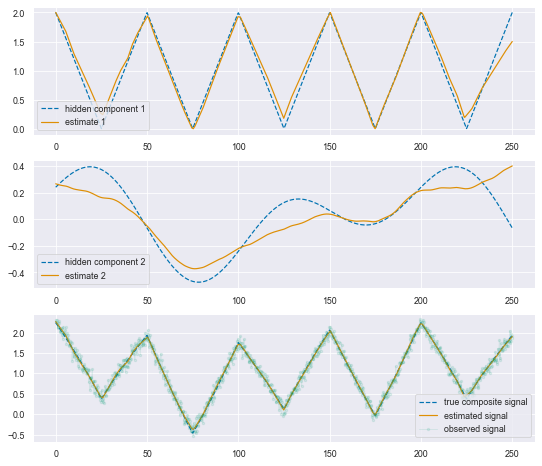

In [23]:
fig, ax = plt.subplots(nrows=3, figsize=(10//1.1, 12//1.5))
ax[0].plot(t, signal1, label='hidden component 1', ls='--')
ax[0].plot(t, problem.estimates[1], label='estimate 1')
ax[1].plot(t, signal2, label='hidden component 2', ls='--')
ax[1].plot(t, problem.estimates[2], label='estimate 2')
ax[2].plot(t, signal1 + signal2, label='true composite signal', ls='--')
ax[2].plot(t, problem.estimates[1] + problem.estimates[2], label='estimated signal');
ax[2].plot(t, y, label='observed signal', linewidth=1, marker='.', alpha=0.1);
for a in ax:
    a.legend()

In [87]:
foo = cvx.Parameter((2, 3), value=np.array([[1, 0, 0], [0, 0, 1]]))
bar = cvx.Variable(3)
foo @ bar

Expression(AFFINE, UNKNOWN, (2,))

In [84]:
bar[foo]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [82]:
foo.value

array([1., 0., 1.])

In [15]:
problem.problem.parameters()

[Parameter((3,), nonneg=True)]

In [18]:
import cvxpy as cvx
import torch
from cvxpylayers.torch import CvxpyLayer

In [29]:
# def create_layer(osd_problem):
#     prob = osd_problem.problem
#     layer = CvxpyLayer(
#         prob,
#         parameters=prob.parameters(),
#         variables=prob.variables())
#     return layer
    
def create_layer(signal_length, index_set):
    n = signal_length
    y_cvx = cvx.Variable(n)
    x1_cvx = cvx.Variable(n)
    x2_cvx = cvx.Variable(n)
    x3_cvx = cvx.Variable(n)
    y_data = cvx.Parameter(n)
    weight_param = cvx.Parameter(2, pos=True)
    costs = [cvx.sum_squares(x1_cvx), cvx.sum_squares(cvx.diff(x2_cvx, k=2)), cvx.sum(cvx.abs(cvx.diff(x3_cvx, k=1)))]
    objective = costs[0] + weight_param[0] * costs[1] + weight_param[1] * costs[2]
    constraints = [
        y_cvx == x1_cvx + x2_cvx + x3_cvx,
        y_cvx[index_set] - y_data[index_set] == 0
    ]
    prob = cvx.Problem(cvx.Minimize(objective), constraints)
    layer = CvxpyLayer(
        prob,
        parameters=[y_data, weight_param],
        variables=[x1_cvx, x2_cvx, x3_cvx]
    )
    return layer

In [30]:
index_set = np.random.uniform(size=len(y)) > 0.2
layer = create_layer(len(y), index_set)

In [14]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from cvxpylayers.torch import CvxpyLayer

torch.set_default_dtype(torch.double)

from tqdm.notebook import tqdm


def fit(loss, params, X, Y, Xval, Yval, batch_size=128, lr=1e-3, epochs=100, verbose=False, print_every=1, callback=None):
    """

    Arguments:
        loss: given x and y in batched form, evaluates loss.
        params: list of parameters to optimize.
        X: input data, torch tensor.
        Y: output data, torch tensor.
        Xval: input validation data, torch tensor.
        Yval: output validation data, torch tensor.
    """

    train_dset = TensorDataset(X, Y)
    train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
    opt = torch.optim.Adam(params, lr=lr)

    train_losses = []
    val_losses = []
    for epoch in tqdm(range(epochs)):
        if callback is not None:
            callback()
            
        with torch.no_grad():
            val_losses.append(loss(Xval, Yval).item())
        if verbose and epoch % print_every == 0:
            print("val loss %03d | %3.5f" % (epoch + 1, val_losses[-1]))

        batch = 1
        train_losses.append([])
        for Xbatch, Ybatch in train_loader:
            opt.zero_grad()
            l = loss(Xbatch, Ybatch)
            l.backward()
            opt.step()
            train_losses[-1].append(l.item())
            if verbose and epoch % print_every == 0:
                print("batch %03d / %03d | %3.5f" %
                      (batch, len(train_loader), np.mean(train_losses[-1])))
            batch += 1
    return val_losses, train_losses

In [ ]:
weights_tch = torch.tensor([1e7, 1e1], requires_grad=True)

def loss_fn(Y, index_set, cvx_layer):
    preds = cvx_layer(X, weights_tch)[0]
    mse_per_example = (preds - actual).pow(2).mean(axis=1)
    return mse_per_example.mean()

In [33]:
weights_tch = torch.tensor([1e7, 1e1], requires_grad=True)
layer(torch.tensor(y, requires_grad=True), weights_tch)

/Users/bennetmeyers/miniconda3/envs/layers/lib/python3.7/site-packages/diffcp/cone_program.py:282: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")


(tensor([ 0.0290, -0.0017,  0.0063,  ..., -0.0173,  0.0133, -0.0152],
        grad_fn=<_CvxpyLayerFnFnBackward>),
 tensor([0.1582, 0.1654, 0.1720,  ..., 0.2253, 0.2187, 0.2118],
        grad_fn=<_CvxpyLayerFnFnBackward>),
 tensor([0.9380, 0.8059, 0.9911,  ..., 0.4748, 0.8468, 0.7653],
        grad_fn=<_CvxpyLayerFnFnBackward>))

# Simple implementation of ADMM algorithm

Nothing fancy here. Just a quick and dirty implementation of the three proximal operators.

In [34]:
def prox1(v, theta, rho):
    r = rho / (2 * theta + rho)
    return r * v

def prox2(v, theta, rho, A=None, return_A=True):
    if A is None:
        n = len(v)
        M = np.diff(np.eye(n), axis=0, n=2)
        r = 2 * theta / rho
        A = np.linalg.inv(np.eye(n) + r * M.T.dot(M))
    if not return_A:
        return A.dot(v)
    else:
        return A.dot(v), A

def prox3_cvx(v, theta, rho):
    n = len(v)
    M = np.diff(np.eye(n), axis=0, n=1)
    x = cvx.Variable(n)
    cost = theta * cvx.norm1(cvx.diff(x)) + (rho / 2) * cvx.sum_squares(x - v)
    problem = cvx.Problem(cvx.Minimize(cost), [cvx.sum(x) == 0])
    problem.solve(solver='MOSEK')
    return x.value

def calc_obj(y, x2, x3, rho1=1, rho2=1e7, rho3=1e1):
    x1 = y - x2 - x3
    t1 = rho1 * np.sum(np.power(x1, 2))
    t2 = rho2 * np.sum(np.power(np.diff(x2, 2), 2))
    t3 = rho3 * np.sum(np.abs(np.diff(x3, 1)))
    return t1 + t2 + t3

def run_admm(data, num_iter=50, rho=0.5, verbose=True, prox3=prox3_cvx):
    y = data
    A = None
    u = np.zeros_like(y)
    x1 = y / 3
    x2 = y / 3
    x3 = y / 3
    residuals = []
    obj_vals = []
    ti = time()
    for it in range(num_iter):
        if verbose:
            td = time() - ti
            progress(it, num_iter, '{:.2f} sec'.format(td))
        x1 = prox1(x1 - u, 1, rho)
        x2, A = prox2(x2 - u, 1e7, rho, A=A, return_A=True)
        x3 = prox3(x3 - u, 1e1, rho)
        u += 2 * (np.average([x1, x2, x3], axis=0) - y / 3)
        # mean-square-error
        error = np.sum([x1, x2, x3], axis=0) - y
        mse = np.sum(np.power(error, 2)) / error.size
        residuals.append(mse)
        obj_vals.append(calc_obj(y, x2, x3))
    if verbose:
        td = time() - ti
        progress(it + 1, num_iter, '{:.2f} sec\n'.format(td))
    outdict = {
        'x1': x1,
        'x2': x2,
        'x3': x3,
        'u': u,
        'residuals': residuals,
        'obj_vals': obj_vals
    }
    return outdict

In [35]:
run1 = run_admm(y, num_iter=1000, rho=1e-1)
run2 = run_admm(y, num_iter=1000, rho=1e0)
run3 = run_admm(y, num_iter=1000, rho=1e1)

[============================================================] 100.0% ...255.92 sec
[============================================================] 100.0% ...234.53 sec
[============================================================] 100.0% ...250.25 sec


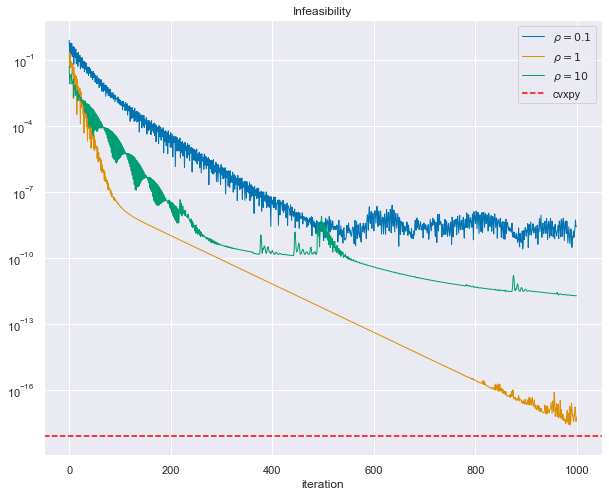

In [36]:
error = np.sum(problem.estimates, axis=0) - y
mse = np.sum(np.power(error, 2)) / error.size
plt.figure(figsize=(10,8))
plt.plot(run1['residuals'], label='$\\rho=0.1$', linewidth=1)
plt.plot(run2['residuals'], label='$\\rho=1$', linewidth=1)
plt.plot(run3['residuals'], label='$\\rho=10$', linewidth=1)
plt.axhline(mse, ls='--', color='red', label='cvxpy')
plt.yscale('log')
plt.legend(loc=1)
plt.title('Infeasibility')
plt.xlabel('iteration');

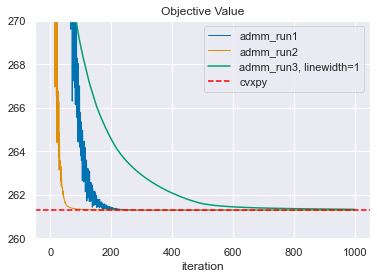

In [67]:
plt.plot(run1['obj_vals'], label='admm_run1', linewidth=1)
plt.plot(run2['obj_vals'], label='admm_run2', linewidth=1)
plt.plot(run3['obj_vals'], label='admm_run3, linewidth=1')
plt.axhline(problem.problem.value, ls='--', color='red', label='cvxpy')
plt.legend()
plt.title('Objective Value')
plt.xlabel('iteration')
plt.ylim(260, 270);

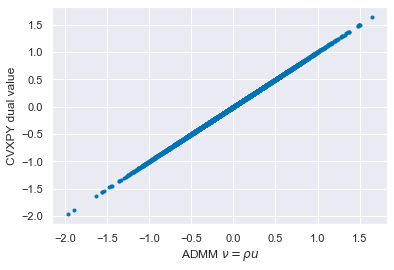

In [63]:
plt.plot(1e0 * run2['u'], problem.problem.constraints[-1].dual_value, ls='none', marker='.')
plt.xlabel('ADMM $\\nu = \\rho u$')
plt.ylabel('CVXPY dual value');

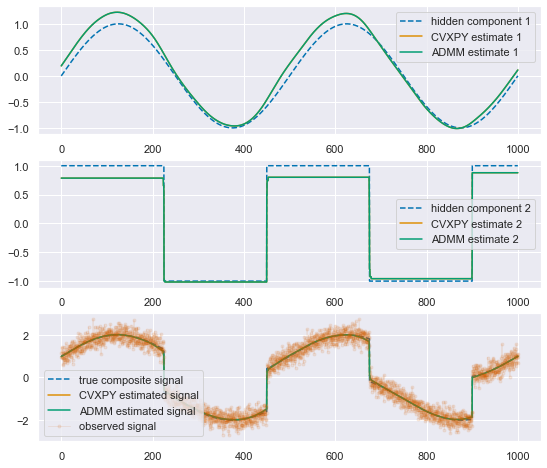

In [64]:
fig, ax = plt.subplots(nrows=3, figsize=(10//1.1, 12//1.5))
ax[0].plot(t, signal1, label='hidden component 1', ls='--')
ax[0].plot(t, problem.estimates[1], label='CVXPY estimate 1')
ax[0].plot(t, run2['x2'], label='ADMM estimate 1')
ax[1].plot(t, signal2, label='hidden component 2', ls='--')
ax[1].plot(t, problem.estimates[2], label='CVXPY estimate 2')
ax[1].plot(t, run2['x3'], label='ADMM estimate 2')
ax[2].plot(t, signal1 + signal2, label='true composite signal', ls='--')
ax[2].plot(t, problem.estimates[1] + problem.estimates[2], label='CVXPY estimated signal');
ax[2].plot(t, run2['x2'] + run2['x3'], label='ADMM estimated signal');
ax[2].plot(t, y, label='observed signal', linewidth=1, marker='.', alpha=0.1);
for a in ax:
    a.legend()

# Non-convex model

Replace the heuristic for a sparse first difference with the constraint that $x^3\in\left\{-1,1\right\}^T$. Objective function is calculated using the L1-heuristic to allow for an apples-to-apples comparison to previous results.

In [54]:
def prox3_noncvx(v, theta, rho):
    v1 = np.ones_like(v)
    v2 = -1 * np.ones_like(v)
    d1 = np.abs(v - v1)
    d2 = np.abs(v - v2)
    x = np.ones_like(v1)
    x[d2 < d1] = -1
    return x

In [55]:
run_noncvx = run_admm(y, num_iter=1000, rho=5, prox3=prox3_noncvx)

[============================================================] 100.0% ...4.95 sec


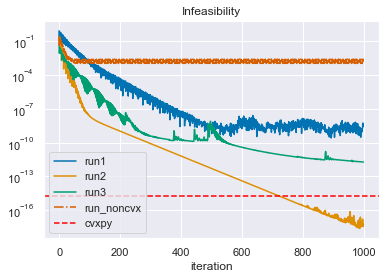

In [56]:
r = np.linalg.norm(
    np.average(problem.estimates, axis=0) - y / 3
)
plt.plot(run1['residuals'], label='run1')
plt.plot(run2['residuals'], label='run2')
plt.plot(run3['residuals'], label='run3')
plt.plot(run_noncvx['residuals'], label='run_noncvx', ls='-.')
plt.axhline(r, ls='--', color='red', label='cvxpy')
plt.yscale('log')
plt.legend()
plt.title('Infeasibility')
plt.xlabel('iteration');

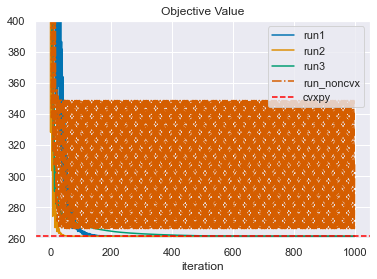

In [61]:
plt.plot(run1['obj_vals'], label='run1')
plt.plot(run2['obj_vals'], label='run2')
plt.plot(run3['obj_vals'], label='run3')
plt.plot(run_noncvx['obj_vals'], label='run_noncvx', ls='-.')
plt.axhline(problem.problem.objective.value, ls='--', color='red', label='cvxpy')
plt.legend()
plt.title('Objective Value')
plt.xlabel('iteration')
plt.ylim(260, 400);

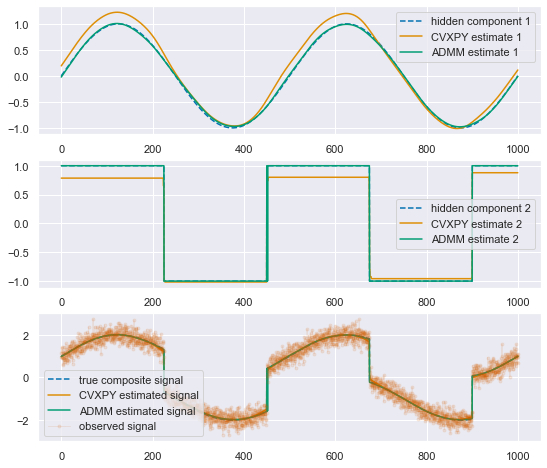

In [62]:
fig, ax = plt.subplots(nrows=3, figsize=(10//1.1, 12//1.5))
ax[0].plot(t, signal1, label='hidden component 1', ls='--')
ax[0].plot(t, problem.estimates[1], label='CVXPY estimate 1')
ax[0].plot(t, run_noncvx['x2'], label='ADMM estimate 1')
ax[1].plot(t, signal2, label='hidden component 2', ls='--')
ax[1].plot(t, problem.estimates[2], label='CVXPY estimate 2')
ax[1].plot(t, run_noncvx['x3'], label='ADMM estimate 2')
ax[2].plot(t, signal1 + signal2, label='true composite signal', ls='--')
ax[2].plot(t, problem.estimates[1] + problem.estimates[2], label='CVXPY estimated signal');
ax[2].plot(t, run_noncvx['x2'] + run_noncvx['x3'], label='ADMM estimated signal');
ax[2].plot(t, y, label='observed signal', linewidth=1, marker='.', alpha=0.1);
for a in ax:
    a.legend()